In [234]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [235]:
year=2019
quarter=3

moneyMultiplier=0

In [236]:
dropColumns=["tbl","citymarketid_1","citymarketid_2","airportid_1","airportid_2","tbl1apk"]
data=pd.read_csv('US Airline Flight Routes and Fares 1993-2024.csv').drop(columns=dropColumns).dropna().reset_index(drop=True)
data=data.loc[(data["city1"]!="Key West, FL") & (data["city2"]!="Key West, FL") & (data["city1"]!="Tulsa, OK") & (data["city2"]!="Tulsa, OK"),:].reset_index(drop=True)
data=data.loc[(data["Year"]==year) & (data["quarter"]==quarter),:].reset_index(drop=True)
data.head()

C:\Users\alt_user\AppData\Local\Temp\ipykernel_21428\3815099057.py:2: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('US Airline Flight Routes and Fares 1993-2024.csv').drop(columns=dropColumns).dropna().reset_index(drop=True)


,Year,quarter,city1,city2,airport_1,airport_2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2
0,2019,3,"Albuquerque, NM","Boston, MA (Metropolitan Area)",ABQ,BOS,1974,191,301.58,WN,0.3523,269.51,WN,0.3523,269.51,"(35.084248, -106.649241)","(42.358894, -71.056742)"
1,2019,3,"Albuquerque, NM","Los Angeles, CA (Metropolitan Area)",ABQ,BUR,677,62,197.14,WN,0.8697,191.40,WN,0.8697,191.40,"(35.084248, -106.649241)","(34.052238, -118.243344)"
2,2019,3,"Albuquerque, NM","Washington, DC (Metropolitan Area)",ABQ,BWI,1670,306,291.79,WN,0.8598,294.65,AA,0.0795,258.14,"(35.084248, -106.649241)","(38.892062, -77.019912)"
3,2019,3,"Albuquerque, NM","Dallas/Fort Worth, TX",ABQ,DAL,580,317,218.01,WN,0.9997,218.03,WN,0.9997,218.03,"(35.084248, -106.649241)","(40.11086, -77.035636)"
4,2019,3,"Albuquerque, NM","Washington, DC (Metropolitan Area)",ABQ,DCA,1670,235,310.64,WN,0.4081,279.22,WN,0.4081,279.22,"(35.084248, -106.649241)","(38.892062, -77.019912)"


In [237]:
from math import radians, sin, cos, sqrt, asin
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return R * c

In [238]:
data=data.sample(50, random_state=42)

In [239]:
G = nx.Graph()

dataNp=data["city1"].to_numpy()
posNp=data["Geocoded_City1"].to_numpy()
for airport, pos in zip(dataNp,posNp):
    pos=pos.split("(")[-1][:-1]
    latitude,longtitude=pos.split(",")
    pos=(float(latitude),float(longtitude))
    G.add_node(airport,pos=pos)


dataNp=data["city2"].to_numpy()
posNp=data["Geocoded_City2"].to_numpy()
for airport, pos in zip(dataNp,posNp):
    pos=pos.split("(")[-1][:-1]
    latitude,longtitude=pos.split(",")
    pos=(float(latitude),float(longtitude))
    G.add_node(airport,pos=pos)

In [240]:
flights=[]

dfNp=data.to_numpy()

for flight in dfNp:
    origin, dest, distance, fare, originPos, destPos = flight[2], flight[3], flight[6], flight[8], flight[-2], flight[-1]
    flights.append((origin,dest,distance,fare,originPos,destPos))
    G.add_edge(origin,dest,weight=distance,price=fare)

In [241]:
chromosomes=[]
sampleSize=3
start = 'Atlanta, GA (Metropolitan Area)'
end = 'Syracuse, NY'
# Start:  Atlanta, GA (Metropolitan Area)  End:  Syracuse, NY

import random 
def greedy_random_walk(graph, start, target, max_steps=1000):
    path = [(start, 0)]  # Start with the initial node and zero cost.
    current = start
    
    for _ in range(max_steps):
        if current == target:
            return path
        
        # Retrieve neighbors of the current node.
        neighbors = graph.edges(current)
        if not neighbors:
            break  # No path if there are no outgoing edges.
        
        # Optional: Filter out neighbors to avoid cycles.
        valid_neighbors = [(nbr, G.edges[(itself, nbr)]["weight"]) for itself, nbr in neighbors if nbr not in path]
        if not valid_neighbors:
            # If all neighbors lead to a cycle, allow revisiting.
            valid_neighbors = [(nbr, G.edges[(itself, nbr)]["weight"]) for itself, nbr in neighbors]
        # Calculate weights: lower cost edges should have higher probability.


        # We use the inverse of the cost (handling zero cost to avoid division by zero).
        weights = []
        for nbr, cost in valid_neighbors:
            adjusted_cost = cost if cost > 0 else 1e-6  # Avoid division by zero.
            weights.append(1.0 / adjusted_cost)
        
        # Randomly choose the next node based on the computed weights.
        next_node = random.choices(
            [nbr for nbr, _ in valid_neighbors],
            weights=weights,
            k=1
        )[0]

        path.append((next_node, G.edges[(current, next_node)]["weight"] + path[-1][1]))
        current = next_node
    
    # If target wasn't reached within max_steps, return None.
    return None

for _ in range(sampleSize):
    path = greedy_random_walk(G, start, end)
    chromosomes.append(path) if path is not None else None


best=("",float("inf"))
for chrom in chromosomes:
    if chrom[-1][1] < best[1]:
        best=chrom[-1]    
best

('Syracuse, NY', 16913)

In [242]:
def rouletteWheel(chrom,k):
    chrom=sorted(chrom,key=lambda x: x[-1][1])
    chrom=chrom[:k]
    total=sum([1/x[-1][1] for x in chrom])
    probabilities=[(1/x[-1][1])/total for x in chrom]
    return random.choices(chrom,weights=probabilities,k=1)[0]

In [243]:

def crossover(p1,p2):
    p1Set=set([x[0] for x in p1])
    # print(p1Set)
    childs=[]
    for i, node in zip(range(1,len(p2)), p2[1:]):
        if node[0] in p1Set:
            index=-1.5
            for j in range(1,len(p1)):
                if(node[0]==p1[j][0]):
                    index=j
                    break
            # print(index,i)
            if(index==-1.5):
                continue
            child1, child2 =p1[:index]+p2[i:], p2[:i]+p1[index:]

            for j in range(index,index + len(p2[i:])):
                child1[j]=(child1[j][0], G.edges[(child1[j-1][0],child1[j][0])]["weight"] + child1[j-1][-1])

            for j in range(i, i + len(p1[index:])):
                child2[j]=(child2[j][0],G.edges[(child2[j-1][0],child2[j][0])]["weight"] + child2[j-1][-1])
            childs.append(child1)
            childs.append(child2)
    return childs
# childs=crossover(p1,p2)


In [244]:
# s,e=3,5
def mutation(childs, index,s,e):
    try:
        mutation=greedy_random_walk(G,childs[index][s][0],childs[index][e][0])


        for i in range(1,len(mutation)):
            childs[index].insert(s+i,mutation[i])
            childs[index][s+i]=(childs[index][s+i][0],G.edges[(childs[index][s+i-1][0],childs[index][s+i][0])]["weight"] + childs[index][s+i-1][-1])

        for i in range(s+len(mutation),len(childs[2])):
            childs[index][i]=(childs[index][i][0], G.edges[(childs[index][i-1][0],childs[index][i][0])]["weight"] + childs[index][i-1][-1])

    except:
        pass
    # print(len(childs[index]), len(childs))
    return childs

In [245]:
def genetic_algorithm(start, end, sampleSize=100, parentCount=10, generations=100):
    chromosomes = []
    for _ in range(sampleSize):
        path = greedy_random_walk(G, start, end)# Generate initial population using a greedy random walk
        chromosomes.append(path)
    generation = []
    print("chromosomes",len(chromosomes))
    for _ in range(parentCount):
        p1 = rouletteWheel(chromosomes, int(sampleSize * 0.4))
        p2 = rouletteWheel(chromosomes, int(sampleSize * 0.4)) # Select two parents using the roulette wheel selection method
        childs = crossover(p1, p2)
        # Mutation step (currently commented out)
        # Introduces random mutations in some offspring with a low probability (3%)
        print("child Count",len(childs))
        for i in range(len(childs)):
            r= random.random()
            # print("random ",r)
            if r < 0.03:
                s = random.randint(1, len(childs[i]) // 2)
                e = random.randint(s + 1, len(childs[i]) - 1)
                if(e-s>2):
                    print("mutation")
                    childs[i] = mutation(childs, i, s, e)
                    # print(childs[i])
                    # for ar in childs[i]:
                    #     print(ar)
                    #     print(len(ar))
                    # print(len(childs),len(childs[i]))
        for child in childs:
            # print("child",child[-1][1])
            if(type(child[-1][1])!=int):
                childs.remove(child)
                # print(len(childs))
        childs = sorted(childs, key=lambda x: x[-1][1]) # Sort offspring based on the cost

        childs = childs[:len(childs) // 2]
        for child in childs:
            generation.append(child) # Add surviving children to the next generation
        # print(len(generation))

    # Find the best chromosome (shortest or most optimal path)
    best = ("", float("inf"))
    index = -1.5  # Initialize with an invalid index
    for i, chrom in zip(range(len(generation)), generation):
        if chrom[-1][1] < best[1]:
            best = chrom[-1]
            index = i 
    return generation[index]  # Return the best path

# Execute the genetic algorithm and get the best route
route = genetic_algorithm(start, end, sampleSize=50, parentCount=10, generations=100)
route[-1][-1]

chromosomes 50
child Count 6
child Count 8
child Count 8
child Count 8
mutation
child Count 42
mutation
child Count 10
child Count 20
child Count 22
child Count 6
mutation
child Count 6


2383

In [246]:
path=[]
for node in route:
    path.append(node[0])
path

['Atlanta, GA (Metropolitan Area)',
 'Houston, TX',
 'New York City, NY (Metropolitan Area)',
 'Syracuse, NY']

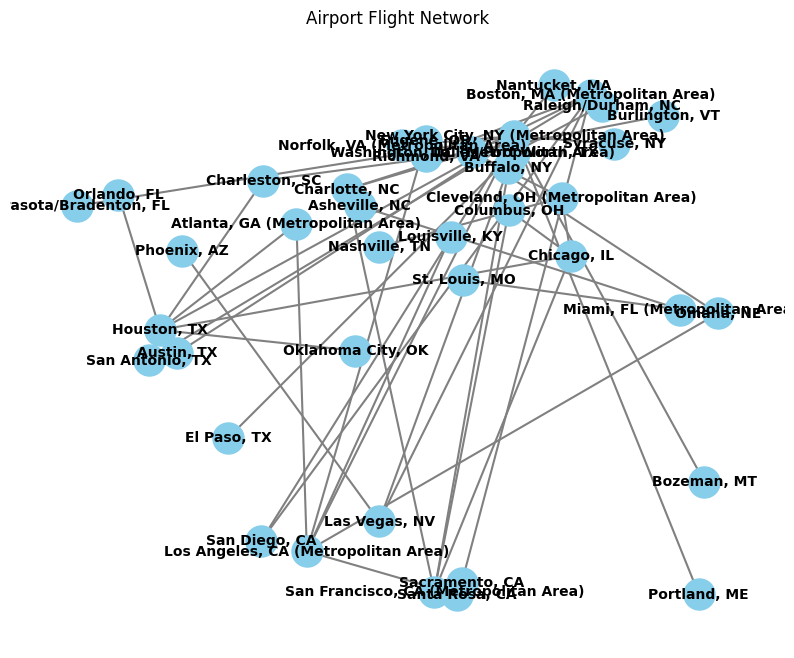

In [247]:
plt.figure(figsize=(10, 8)),
# pos = nx.spring_layout(G, seed=42)
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="skyblue")
nx.draw_networkx_edges(G, pos, width=1.5, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

# Add edge labels (distance)
edge_labels = nx.get_edge_attributes(G, "distance")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

plt.title("Airport Flight Network")
plt.axis("off")
plt.show()

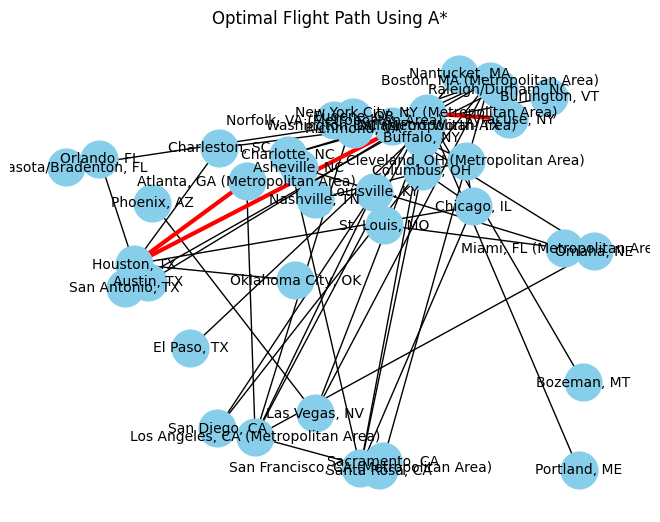

In [248]:

nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10)

# Highlight the optimal path
path_edges = list(zip(path, path[1:]))
nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=3)

plt.title("Optimal Flight Path Using A*")
plt.show()